# Temporal Community Detection

_______
# Table of Contents #

1. Introduction to temporal networks
   - Definition and examples
   - Visualizing temporal networks
3. Community detection in temporal networks
   - Modularity (multilayer Q) maximization
   - Static community detection + community alignment
4. Characterizing temporal community structure
   - Calculating diagnostics
4. Comparing diagnostics to null models

______

# Introduction to Temporal Networks #

Real-world networks are not typically fixed across time, but are instead ever-changing. We can model these dynamic, or temporal, networks, as **multilayer graphs**. 


  ![Bassett et al., 2011. Figure 3](Bassett2011_fig3ab.png)

Each layer of the multilayer graph is a snapshot of the network at a given time. The next layer is another snapshot of the network at the following timepoint, and so on. Analyzing these multilayer graphs may provide insight into the dynamics and evolution of our network.

Here are two examples of research that utilized temporal multilayer graphs.


## Example 1: Financial Asset Correlation Networks ##

![Bazzi et al., 2016](figures/bazzi2016_title.png)

In Bazzi et al., 2016, researchers examined correlations between prices of financial assets, such as government bonds, currencies, and metals, between 1999 and 2010. Each financial asset was a node in the graph and each layer  represented a timepoint at which the financial asset correlations were measured. They analyzed these graphs using a community detection approach and observed changes in community structure corresponding to known financial events (such as the crash of 2008). They also observed changes in community size over time.

![Bazzi et al., 2016](figures/Bazzi2016_assets.png)

## Example 2 - Brain Network Connectivity Dynamics ##

![Bassett et al., 2011](figures/bassett2011_title.png)

In Bassett et al., 2011, researchers used multilayer networks to model changes in brain network functional connectivity (as determined by blood-oxygenation dynamics) over time. Each layer in their multilayer graphs represented brain connectivity at a given time. They examined how modular configuration, or the community structure within these brain connectivity snapshots, changed over time. They found that the extent to which modular configuration changed over time was a predictor of performance on the motor learning task that the subjects performed during their fMRI scan.



![Bassett et al., 2011](figures/bassett2011_2c.png)


(Bassett et al., 2011)

Before we dive into analysis, **let's learn how to visually depict these multilayer networks.**


In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from matplotlib import colormaps
from networkx import community
import community
import seaborn as sns

First, we will construct a multilayer graph, using the karate club graph as our foundation. 

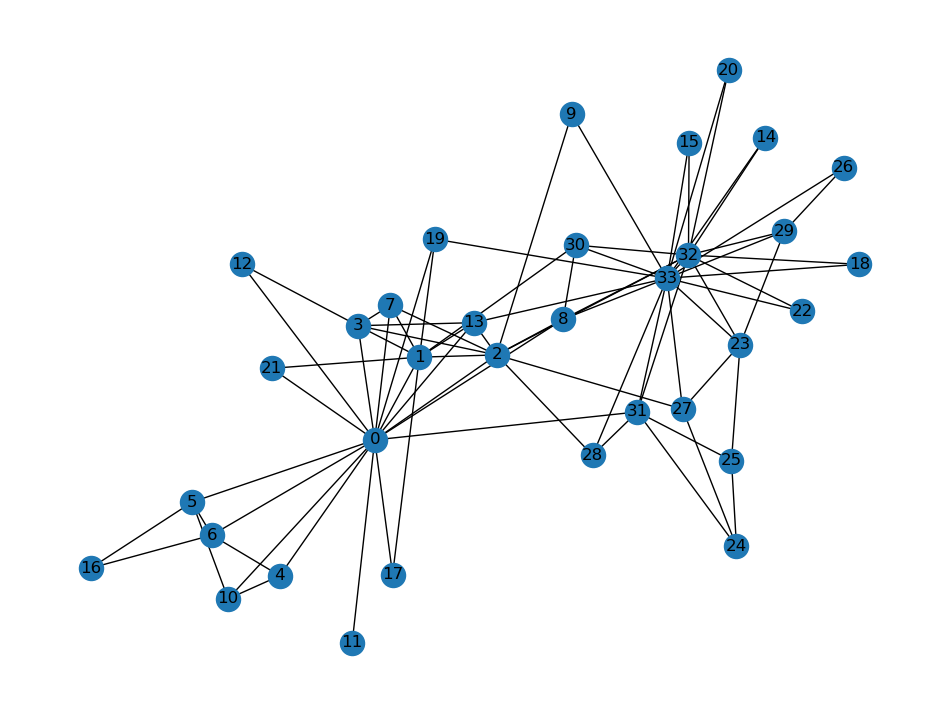

In [6]:

fig, ax = plt.subplots(1,1,figsize=(12,9))

G = nx.karate_club_graph()
pos = nx.spring_layout(G)

nx.draw(G,pos=pos,ax=ax,with_labels=True)

This will be our first layer (time=0). We will create subsequent layers by randomly removing and adding some edges.

This function randomly shuffles some of the connections to create timepoint 2 and 3 graphs:

In [8]:
#Multilayer karate club graph


def random_shuffle(G,n):
    """
    Randomly removes n edges and then randomly adds n edges. 
    Does not preserve degree distribution.

    Parameters
    ------------
    G: networkx Graph
    Graph to shuffle

    n: integer
    Number of iterations

    Output
    -----------
    shuffled_G: networkx Graph
    Shuffled graph

    """
    G_shuffle = G.copy()
    
    edges = list(G_shuffle.edges())
    weights = [G_shuffle[u][v]['weight'] for u, v in G_shuffle.edges()]

    for u,v in G_shuffle.edges():
        G_shuffle[u][v]['color']="black"
    
    max_weight = np.max(weights)
    min_weight = np.min(weights)
    
    nodes = list(G_shuffle.nodes())
    
    
    

    for i in range(n):
        edge = edges[np.random.choice(range(len(edges)))]
        
        G_shuffle.remove_edge(edge[0],edge[1])

        node_1 = np.random.choice(nodes)
        node_2 = np.random.choice(nodes)
        if node_1 != node_2:
            G_shuffle.add_edge(node_1,node_2)
            G_shuffle[node_1][node_2]['color']="red"
            G_shuffle[node_1][node_2]['weight']=np.random.randint(min_weight,max_weight)
        else:
            continue
        edges = list(G_shuffle.edges())

    return G_shuffle
    



Text(0.5, 1.0, 'Time = 2')

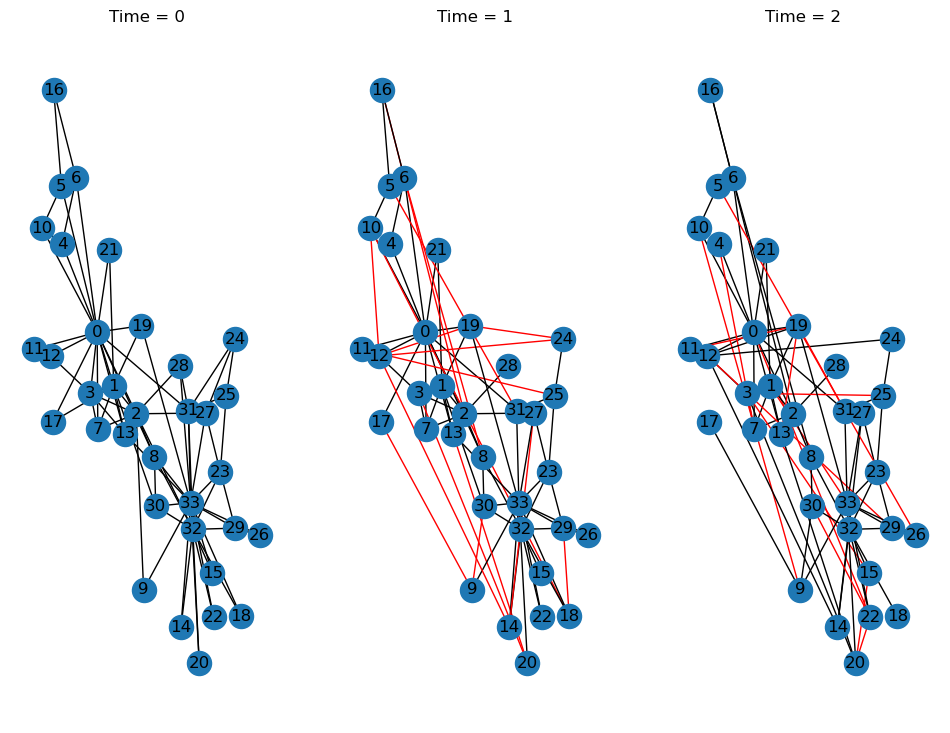

In [13]:
#Creating timepoints 1, 2, and 3 graphs.

fig, ax = plt.subplots(1,3,figsize=(12,9))


G = nx.karate_club_graph()
pos = nx.spring_layout(G)



G_t1 = G
G_t2 = random_shuffle(G_t1,20)
G_t3 = random_shuffle(G_t2,20)

nx.draw(G_t1,pos=pos,ax=ax[0],with_labels=True)
ax[0].set_title("Time = 0")

edge_colors = [G_t2[u][v]['color'] for u, v in G_t2.edges()]
nx.draw(G_t2,pos=pos,ax=ax[1],with_labels=True,edge_color=edge_colors)
ax[1].set_title("Time = 1")

edge_colors = [G_t3[u][v]['color'] for u, v in G_t3.edges()]
nx.draw(G_t3,pos=pos,ax=ax[2],with_labels=True,edge_color=edge_colors)
ax[2].set_title("Time = 2")


The edges that were added at each step are highlighted in red.

**How can we create a cool 3D visualization of our multilayer graph like this one?**

![Ghawi and Pfeffer 2022](figures/multilayer_vert.png)
(Ghawi and Pfeffer 2022) 

Let's adapt code from user Paul Brodersen on StackOverflow [(linked here).](https://stackoverflow.com/questions/60392940/multi-layer-graph-in-networkx) We create a class called LayeredNetworkGraph and then create an instance of that class.

In [18]:
# Constructing and visualizing a multilayer graph from a list of single timepoint graphs

# Posted by Paul Brodersen, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-30, License - CC BY-SA 4.0

#!/usr/bin/env python
"""
Plot multi-graphs in 3D.
"""

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection


class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=300, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)



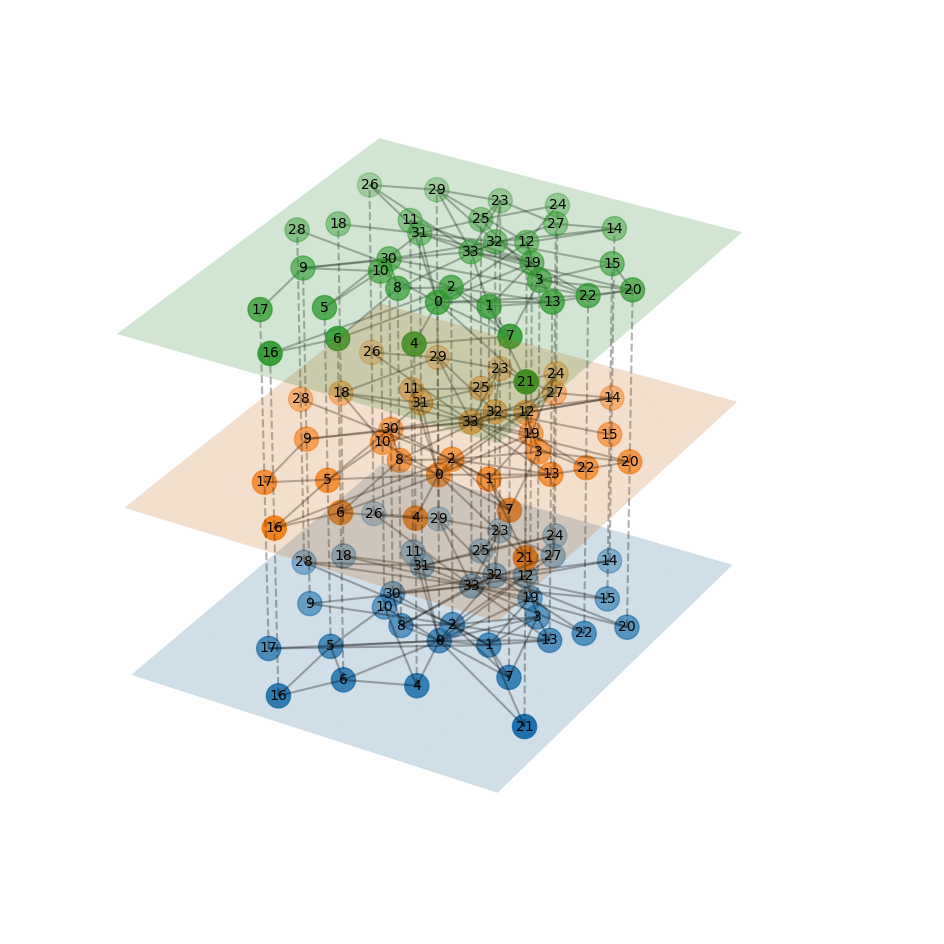

In [20]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
node_labels = list(G_t1.nodes())
LayeredNetworkGraph([G_t1, G_t2, G_t3], node_labels=node_labels, ax=ax, layout=nx.spring_layout)



ax.set_zticks([0,0.87,1.87])
ax.set_zticklabels(['t=0','t=1','t=2'],fontsize=20)

ax.set_xticks([])
ax.set_yticks([])


ax.set_axis_off() # optional

**Challenge: Try making a horizontal version of this plot with layers arranged across the x-axis.**

Like this:

![Mucha et al., 2010](figures/mucha2010_multilayer.png)
(Mucha et al., 2010)

In [1185]:
# Your Turn


______
# Community Detection in Temporal Multilayer Networks #



**Community detection** is a key tool in network science. Typically, community detection involves identifying groups of nodes within graphs that are more densely connected to each other than they are to the rest of the network. Here is a reminder of the mathematical definition of a community from Chapter 08.

> ### What is a Community?
>   A **community** in a network can be intuitively understood as a subset of nodes where connections (edges) between members of the community are more frequent or stronger than connections to the rest of the network. In mathematical terms, a graph $G = (V, E)$, where $ V $ represents the set of nodes and $ E $ represents the set of edges, can be partitioned into communities $ C_1, C_2$, ..., $C_k $ such that:
> $$
\sum_{i=1}^{k} \left( \text{Intra-community edges in } C_i \right) \gg \text{Inter-community edges between } C_i \text{ and other communities}.
$$
> This means that each community $ C_i $ has a higher density of internal connections compared to its connections to other communities in the network.

Various algorithms have been designed for this purpose. 

Modularity maximization is one approach to community detection. (It can be [problematic](https://skewed.de/lab/posts/modularity-harmful/), so we will also discuss alternatives later on).

This method typically relies on the calculation of a metric called Q.



## Modularity maximization  ##



$Q (A,C) = \frac{1}{2M} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2M} \right) \delta (C_i,C_j) $




There are various modularity maximization techniques. First, we will use the Louvain algorithm. Here is a reminder of how it works:

>The **Louvain method** is a popular greedy optimization technique for maximizing modularity. It works in two phases:
    >1. **Local Modularity Maximization**: Each node is initially assigned to its own community. Nodes are then reassigned to neighboring communities if doing so increases modularity.
    >2. **Community Aggregation**: Once no more reassignments can improve modularity, the network is compressed by treating each community as a “super-node.”
>  This process is repeated until no further improvement in modularity is possible.



We can use the best_partition function from the python package community to run the Louvain algorithm. This function performs modularity maximization using the Louvain algorithm. The output is a dictionary with the graph nodes as keys and those nodes' community affiliations as values. 

In [22]:
#Detecting community structure in networkx

t1_partition = community.best_partition(G_t1)



print(f"The louvain_communities algorithm outputs a dictionary: {t1_partition}")



The louvain_communities algorithm outputs a dictionary: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 3, 9: 3, 10: 1, 11: 0, 12: 0, 13: 0, 14: 3, 15: 3, 16: 1, 17: 0, 18: 3, 19: 0, 20: 3, 21: 0, 22: 3, 23: 3, 24: 2, 25: 2, 26: 3, 27: 3, 28: 2, 29: 3, 30: 3, 31: 2, 32: 3, 33: 3}


Let's try running this for each layer of our multilayer karate club graph.

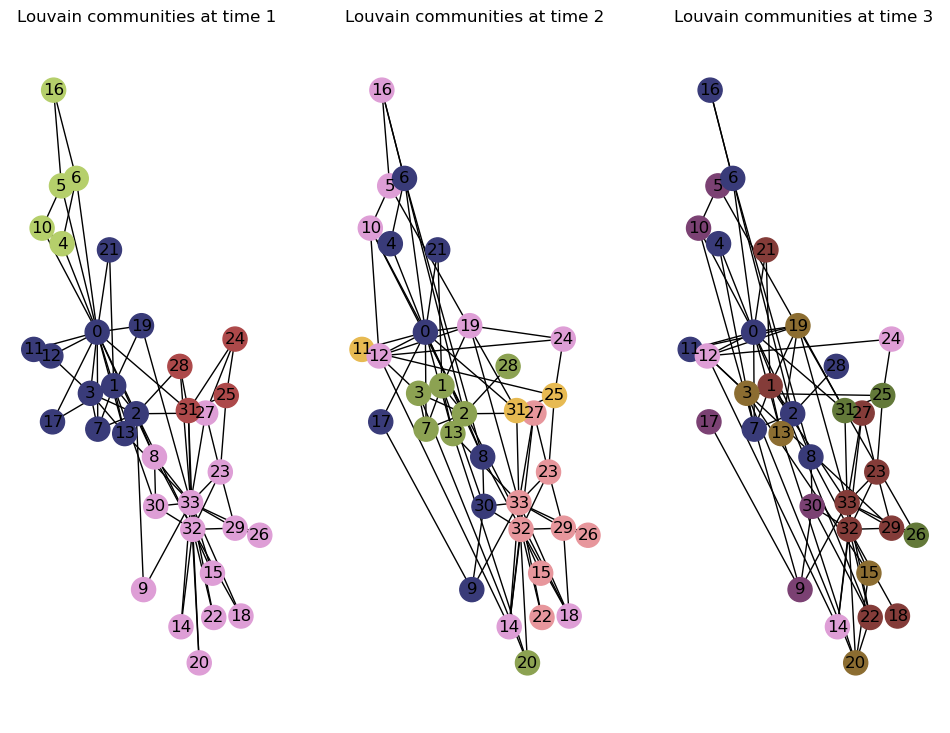

In [24]:
#Comparing partitions across timepoints


t2_partition = community.best_partition(G_t2)

t3_partition = community.best_partition(G_t3)


fig, ax = plt.subplots(1,3,figsize=(12,9))
kc_partitions = [t1_partition,t2_partition,t3_partition]
kc_graphs = [G_t1,G_t2,G_t3]

for i in range(3):
    partition = kc_partitions[i]
    unique_comms = np.unique(list(partition.values()))
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))
    
    node_colors = [comm_color_dict[partition[i]] for i in kc_graphs[i].nodes]
    
    
    
    nx.draw(kc_graphs[i], pos=pos, node_color=node_colors, with_labels=True, ax=ax[i])
    ax[i].set_title(f"Louvain communities at time {i+1}")

plt.show()


Let's try this with another example where we know the ground-truth modular organization. Here, we will generate graphs from stochastic block models. They will decrease in assortativeness over time.

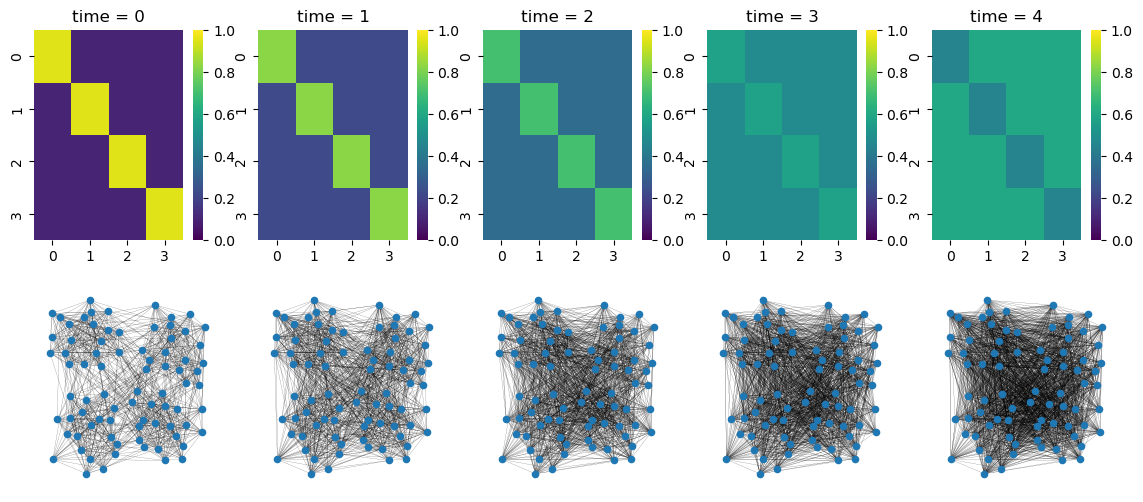

In [26]:
#Generating graphs from stochastic block model

layers = 5 #number of layers in multilayer graph
clusters = 4 #number of communities
nodes_per = 20 #number of nodes per community
intra = 0.95 #(initial) probability of within-community edges
inter = 0.1 #(initial) probability of inter-community edges
change = 0.125


prob_matrices = [[[
    (intra if i == j else inter) + (t * change * (-1 if i == j else 1))
    for j in range(clusters)]
    for i in range(clusters)]
    for t in range(layers)]

fig, ax = plt.subplots(2,5,figsize=(14,6))

#plotting sbm matrices

vmin = 0
vmax = 1
cmap="viridis"

for i in range(layers):
    
    sns.heatmap(prob_matrices[i],ax=ax[0,i],vmin=vmin,vmax=vmax,cmap=cmap)
    ax[0,i].set_title(f'time = {i}')

#creating graphs

sbm_graphs = []


for i in range(layers):
    sbm_graphs.append(nx.stochastic_block_model(clusters*[nodes_per], prob_matrices[i], seed=1))
    sbm_graphs[i].name = i

pos=nx.spring_layout(sbm_graphs[0])
for i in range(layers):
    nx.draw(sbm_graphs[i], pos=pos, ax=ax[1,i],node_size=20,width=0.1)





Now let generate partitions at each timepoint using the Louvain algorithm:

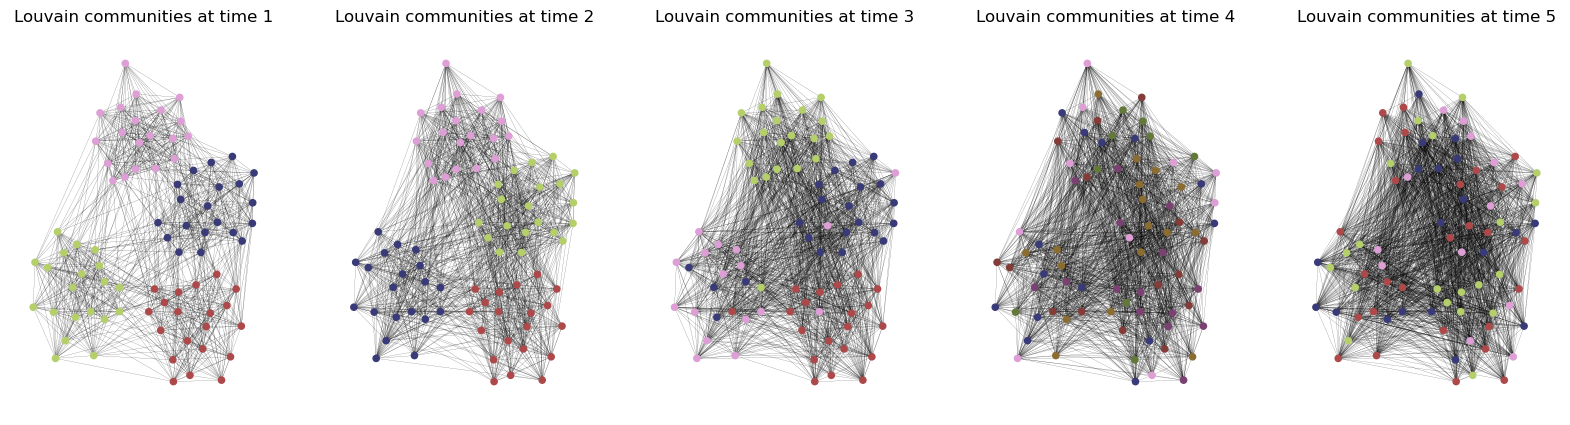

In [60]:
#Comparing partitions across timepoints

sbm_partitions_louvain = []
for layer in sbm_graphs:
    part = community.best_partition(layer)
    sbm_partitions_louvain.append(part)
    


fig, ax = plt.subplots(1,5,figsize=(20,5))



for i in range(5):
    partition = sbm_partitions_louvain[i]
    unique_comms = np.unique(list(partition.values()))
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))
    
    node_colors = [comm_color_dict[partition[i]] for i in sbm_graphs[i].nodes]
    
    
    
    nx.draw(sbm_graphs[i], pos=pos, node_color=node_colors, ax=ax[i],node_size=20,width=0.1)
    ax[i].set_title(f"Louvain communities at time {i+1}")

plt.show()

We can use procedures like these to generate toy multilayer graphs with various characteristics. Here's a bonus example with LFR benchmark graphs (Lancichinetti, Fortunato, and Radicchi, 2008). Here we are changing the $\mu$ value over time, resulting in less distinct communities.

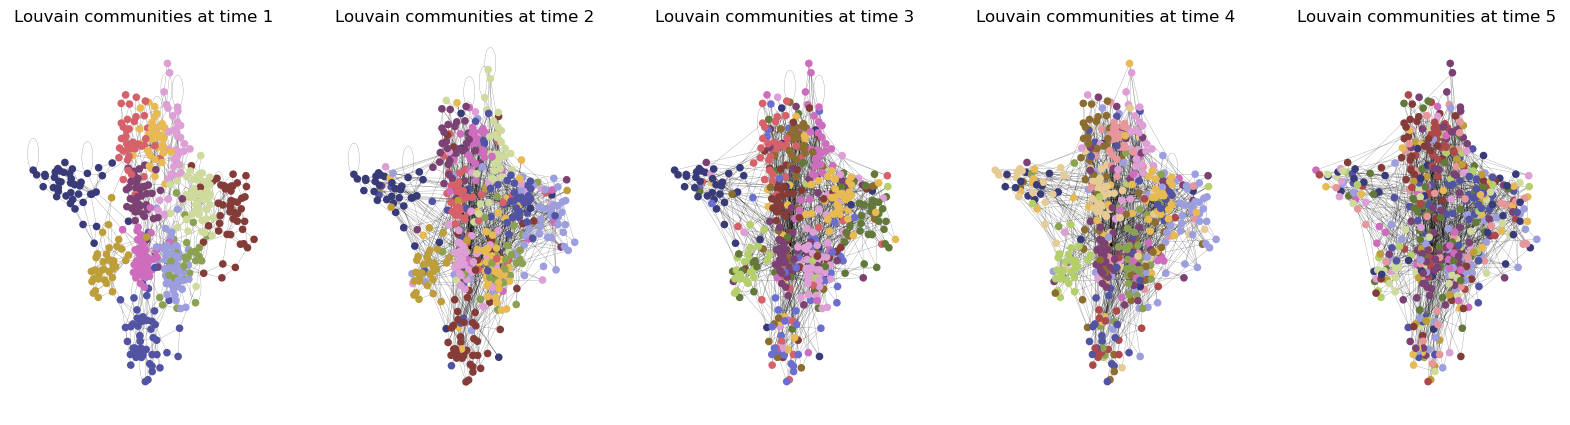

In [30]:
#Comparing partitions across timepoints
from networkx.generators.community import LFR_benchmark_graph

layers = 5
n = 500

graphs = []


for i in range(layers):
    graph = nx.LFR_benchmark_graph(n,tau1=3,tau2=1.5,mu=0.1+0.05*i,average_degree=5,seed=12,min_community=30)
    graphs.append(graph)


partitions = []
for layer in graphs:
    part = community.best_partition(layer)
    partitions.append(part)
    


fig, ax = plt.subplots(1,5,figsize=(20,5))

pos = nx.spring_layout(graphs[0])

for i in range(5):
    partition = partitions[i]
    unique_comms = np.unique(list(partition.values()))
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))
    
    node_colors = [comm_color_dict[partition[i]] for i in graphs[i].nodes]
    
    
    
    nx.draw(graphs[i], pos=pos, node_color=node_colors, ax=ax[i],node_size=20,width=0.1)
    ax[i].set_title(f"Louvain communities at time {i+1}")

plt.show()

From multilayer graphs like these, we can make plots showing node affiliation evolution over time. Here is an example from Bassett et al., 2013:

  ![text](Bassett2013_fig3c.png)


But **there's one problem** we need to solve before we can construct such a plot. Our community assignments are not consistent across timepoints. Take a look at one of the four networks we just identified. Follow that network across time. You will see that the same network has different labels at different times. At time 1, a particular network could be labeled network 1, the red network, and at the next timepoint, a network consisting of mostly the same nodes could be called network 1, the blue network. This makes tracking meaningful network affiliation changes over time difficult. There are two strategies we can use to deal with this.

1) Compute one multilayer network partition across the entire multilayer graph.
2) Compute network partitions separately for each layer and then use an algorithm to reconcile those networks across layers.

Let's learn how to use both of these strategies!


First strategy: We can perform community detection on the entire multilayer network using a generalization of the Q equation.

## Option 1: Multilayer Community Detection ##

With the leidenalg package, we can perform community detection over layers of a multilayer graph.

Leidenalg is a python package for community detection in networks. Unlike the community package we used earlier for community detection, this package includes multilayer community detection functionality. Namely, the find_partition_temporal function allows us to identify one network partition across all layers of a multilayer graph.

Instead of the Louvain algorithm, it uses a multilayer version of the **Leiden algorithm**. (Traag, Waltman, and Van Eck, 2019). It is similar to the Louvain algoritm, but is considered an improvement on it because it yields communities that are guaranteed to be connected.


Let's try using this method on the SBM graphs that we constructed earlier:

In [32]:
import leidenalg as la
import networkx_temporal as tx
import igraph as ig

In [34]:
def leiden_cd(multilayer_G,interslice_weight):

    """
    Runs leidenalg multilayer community detection.

    Parameters
    ------------
    multilayer_G: list of networkx graphs

    interslice_weight: float

    Outputs
    -----------
    membership: list of lists
    Each list contains all node memberships for a given timepoint

    """
    #Converting to igraph objects in order to use leidenalg
    
    for G in multilayer_G: #converting edge weights to floats
        for u, v, data in G.edges(data=True):
            if 'weight' in data:
                data['weight'] = float(data['weight'])
            else:
                data['weight'] = 1.0 
    
    #Make sure names are consistent across layers
    for G in multilayer_G:
        for n in G.nodes():
            G.nodes[n]["_nx_name"] = str(n)   # must be strings for safety
    
    
    multilayer_G_i = [ig.Graph.from_networkx(graph) for graph in multilayer_G] #converting to igraph
    
    #Running community detection algorithm
    
    membership, improvement = la.find_partition_temporal(
        multilayer_G_i,
        la.ModularityVertexPartition,
        interslice_weight=interslice_weight, #can change this parameter
        n_iterations=-1,
        seed=0,
        vertex_id_attr="_nx_name",
        weight_attr="weight")
    
    return membership


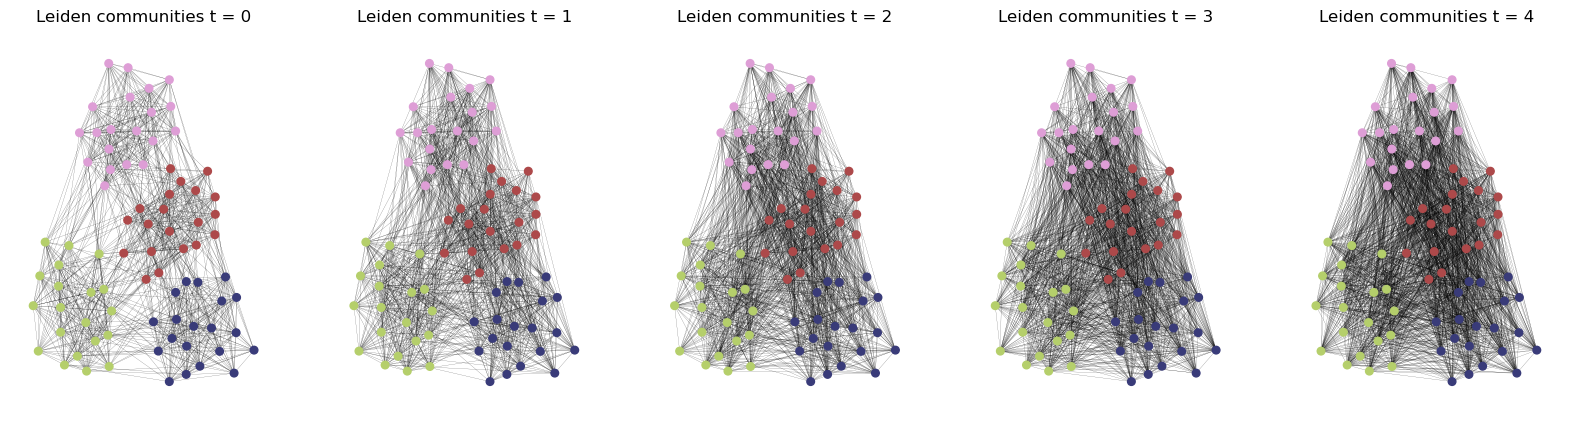

In [48]:

multilayer_G_sbm = sbm_graphs



#plotting


fig, ax = plt.subplots(1,5,figsize=(20,5))
partitions = leiden_cd(multilayer_G_sbm,1)
pos = nx.spring_layout(multilayer_G_sbm[0])

for i in range(5):
    partition = partitions[i]
    unique_comms = np.unique(partition)
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))
    
    node_colors = [comm_color_dict[partition[i]] for i in multilayer_G_sbm[i].nodes]
    
    
    
    nx.draw(multilayer_G_sbm[i], pos=pos, node_color=node_colors,  ax=ax[i],node_size=30,width=0.1)
    ax[i].set_title(f"Leiden communities t = {i}")

plt.show()


Communities are the same across layers. Let's try changing the **coupling parameter**.

The coupling parameter, ($\omega$), controls how much the same nodes are connected to each other across layers. You can change this parameter to control how unique across layers you'd like your community assignments to be.

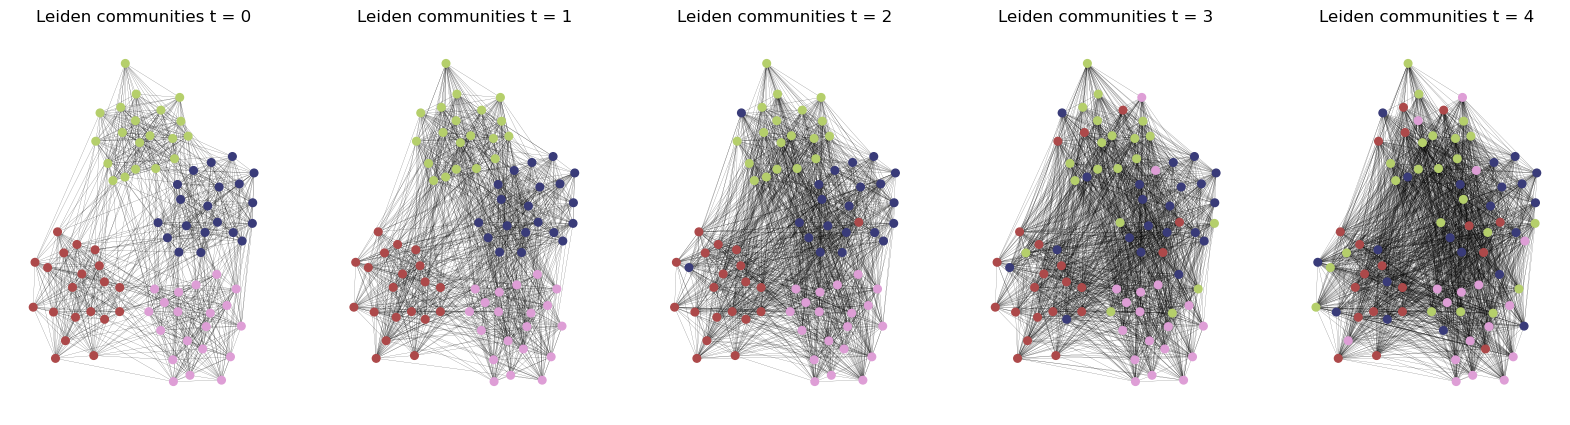

In [50]:
#Running community detection algorithm




#plotting

fig, ax = plt.subplots(1,5,figsize=(20,5))
partitions = leiden_cd(multilayer_G_sbm,0.001)
membership_sbm = partitions
pos = nx.spring_layout(multilayer_G_sbm[0])


for i in range(5):
    partition = partitions[i]
    unique_comms = np.unique(partition)
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))
    
    node_colors = [comm_color_dict[partition[i]] for i in multilayer_G_sbm[i].nodes]
    
    
    
    nx.draw(multilayer_G_sbm[i], pos=pos, node_color=node_colors, ax=ax[i],node_size=30,width=0.1)
    ax[i].set_title(f"Leiden communities t = {i}")

plt.show()





Now, we can make a visualization like the one we 


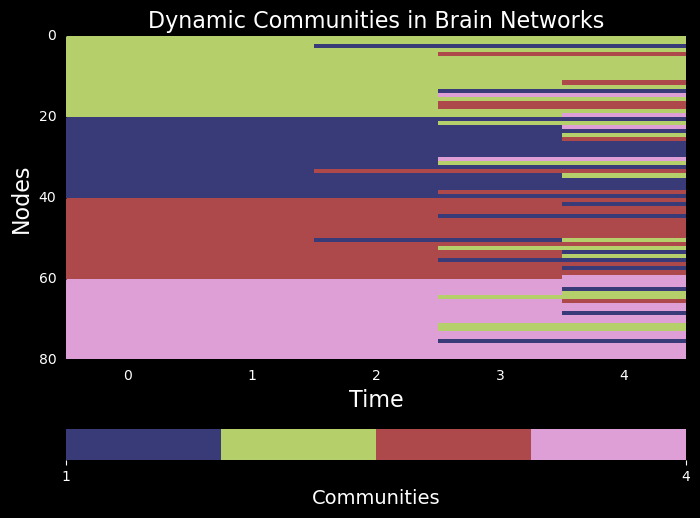

In [52]:
# Code for creating a visualization like the one above.
# Tracking community affiliation changes over time

import seaborn as sns
import matplotlib.colors as mcolors

def community_tracker(multilayer_G,membership):
    """
    Plots community affiliations of nodes over time.

    Parameters
    --------------
    multilayer_G: list of networkx graphs
    List of networkx graphs that consitute your multilayer graph

    membership: list of lists
    List of node community membership lists

    Output
    -------------
    Community tracker plot
    
    """
    num_layers = len(multilayer_G)
    num_nodes = len(list(multilayer_G[0].nodes()))
    
    
    # creating a dictionary with a list of community affiliations over time for each node in the network
    aff_dict = {node:[] for node in list(multilayer_G[0].nodes())}
    for node in list(multilayer_G[0].nodes()):
        for i in range(len(membership)):
            aff_dict[node].append(membership[i][node])
    
    #converting to dataframe
    aff_data = pd.DataFrame(aff_dict).T
    
    
    # (Optional) Sort data
    # aff_data = aff_data.sort_values(by=aff_data.columns[-1], axis=0)
    
    #initializing figure
    fig = plt.figure(figsize=(8,6),facecolor='black')
    vmin_val = aff_data.values.min()
    vmax_val = aff_data.values.max()
    
    #creating color map with one color for each distinct community
    unique_comms = np.unique(list(aff_data[0]))
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))
    color_list = [comm_color_dict[c] for c in unique_comms]
    cmap = mcolors.ListedColormap(color_list)
    
    #plotting heatmap
    ax = sns.heatmap(aff_data,cmap=cmap,cbar_kws={'orientation':'horizontal'}, vmin=vmin_val, vmax=vmax_val)
    ax.set_title("Dynamic Communities in Brain Networks",color='white',fontsize=16)
    ax.set_xlabel('Time', color='white', fontsize=16)
    ax.set_ylabel('Nodes', color='white', fontsize=16)
    
    
    
    #customizing ticks
    xtick_locations = [i+0.5 for i in range(num_layers)]
    xtick_labels = [i for i in range(num_layers)]
    
    ax.set_xticks(xtick_locations) 
    ax.set_xticklabels(xtick_labels, color='white')
    ax.set_yticks([i for i in range(0,num_nodes+1,20)]) #change to match your data
    ax.set_yticklabels([i for i in range(0,num_nodes+1,20)], color='white')
    
    
    
    #customizing colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_color('white')
    cbar.ax.tick_params(colors='white')
    cbar.set_ticks([0,len(unique_comms)-1])
    cbar.set_ticklabels([1,len(unique_comms)])
    cbar.ax.set_xlabel("Communities",color="white",fontsize=14)
    
    
    
    plt.show()
    
    
community_tracker(multilayer_G_sbm, partitions)

## Option 2: Static Community Detection On Each Layer + Community Alignment ##

This approach consists of two steps. 

First, we'll **identify communities** at each timepoint using the community detection algorithm of your choice. 

Second, we'll **align those communities** across the entire multilayer graph. Let's try this on our SBM example.

We used the Louvain algorithm to get partitions at each timepoint. However, we can see by looking at the community tracker plot that these communities are not aligned across time.

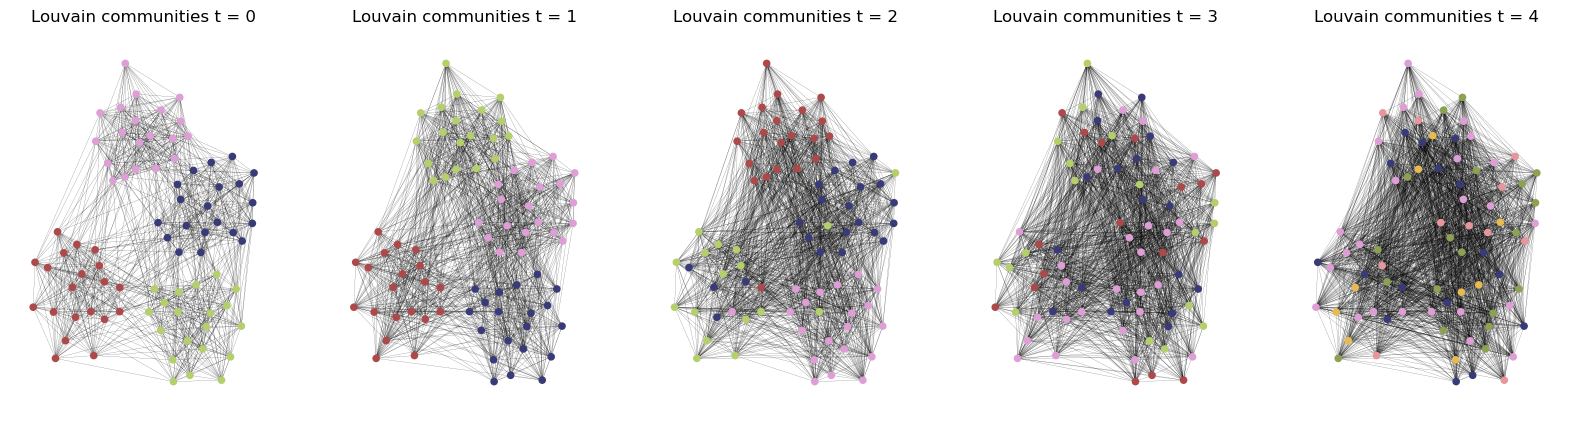

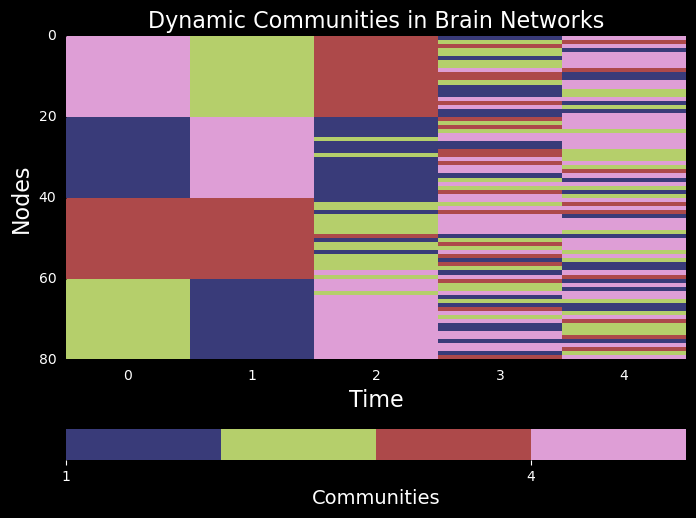

In [54]:

fig, ax = plt.subplots(1,5,figsize=(20,5))



for i in range(5):
    partition = sbm_partitions[i]
    unique_comms = np.unique(list(partition.values()))
    comm_colors = plt.cm.tab20b(np.linspace(0,1,len(unique_comms)))
    comm_color_dict = dict(zip(unique_comms, comm_colors))
    
    node_colors = [comm_color_dict[partition[i]] for i in sbm_graphs[i].nodes]
    
    
    
    nx.draw(sbm_graphs[i], pos=pos, node_color=node_colors, ax=ax[i],node_size=20,width=0.1)
    ax[i].set_title(f"Louvain communities t = {i}")

sbm_partitions_lists = [list(partition.values()) for partition in sbm_partitions]
community_tracker(sbm_graphs,sbm_partitions_lists)



We can use **an alignment strategy to match communities across time.** (Ghawi and Pfeffer 2022)

We will use the first timepoint of our graph as our baseline with which to compare each other graph/layer. 

For each pair of graphs/layers, we will test each pair of communities for Jaccard similarity.

$J(C_1,C_2) = \frac{|nodes(C_1) \cap nodes(C_2)|}{|nodes(C_1) \cup nodes(C_2)|}$

From this, we will match communities to each other based on their similarity. We do this by first constructing a $\text{communities}_{t0} \times \text{communities}_{tx}$ matrix containing those Jaccard similarities and then running the Hungarian algorithm to determine how to match communities such that similarity is maximized. The Hungarian algorithm, developed by Harold Kuhn in 1955, takes an $n \times n$ matrix and selects one value from each row such that one value from each column is also chosen and the sum of all the chosen values are minimized (Kuhn, 1955). It is implemented in scipy using the linear_sum_assignment function.

Let's try this with our sbm graph example.


In [134]:

#Calculate jaccard score between each pair of communities

def jaccard(comm1_nodes,comm2_nodes):
    j = len(comm1_nodes & comm2_nodes) / len(comm1_nodes | comm2_nodes)
    return  j

#convert node:assignment dicts to community:{nodes} format
def convert_comm_dicts(comm_dict):
    out = {}
    for node, c in comm_dict.items():
        out.setdefault(c, set()).add(node)  
    return out
        
    

#gets similarities for each pair of communities
def jaccard_layers(layer1_dict,layer2_dict):
    comms_1 = set(layer1_dict.values())
    comms_2 = set(layer2_dict.values())

    #convert to lists of nodes per community
    converted1 = convert_comm_dicts(layer1_dict)
    converted2 = convert_comm_dicts(layer2_dict)

    similarities = {}
    for c1 in comms_1:
        for c2 in comms_2:
            similarity = jaccard(converted1[c1],converted2[c2])
            similarities[(c1,c2)] = similarity
        
            
from scipy.optimize import linear_sum_assignment

#algorithm for matching
def align_layers(layer1_dict, layer2_dict):
    c1_sets = convert_comm_dicts(layer1_dict)
    c2_sets = convert_comm_dicts(layer2_dict)

    c1 = list(c1_sets.keys())
    c2 = list(c2_sets.keys())

    # Make Jaccard matrix
    M = np.zeros((len(c1), len(c2)))
    for i, a in enumerate(c1):
        for j, b in enumerate(c2):
            M[i, j] = jaccard(c1_sets[a], c2_sets[b])

    # Hungarian algorithm 
    r, c = linear_sum_assignment(-M)

    matches = [(c1[i], c2[j]) for i, j in zip(r, c)]
    return matches


#do this for each layer
layers = sbm_partitions_louvain   #community assignments for unaligned graphs

matches_dict = {}
for i in range(len(layers)-1):
    layer0 = layers[0]
    layerx = layers[i+1]
    matches = align_layers(layer0,layerx)
    matches_dict[(0,i+1)] = matches
    

In [138]:
# Using this mapping to align communities across time.  
# Then creating a community tracker plot to track node affiliation changes.

remapped_partition = [sbm_partitions_louvain[0]]

for i in range(1,len(sbm_partitions_louvain)): # list of dictionaries with node:community

    remap = matches_dict[(0,i)] # matchings between layer 0 and layer i. matches_dict is a dict with (layer 0, layer i): [(comm_layer1:comm_layeri), etc]
    mapping = {comm_i: comm_0 for (comm_0, comm_i) in remap}
    layer_dict = sbm_partitions_louvain[i]

    remapped_layer = {}
    for node in layer_dict:
        if layer_dict[node] in list(mapping.keys()):
            remapped_layer[node] = mapping[layer_dict[node]]
        else:
            remapped_layer[node] = layer_dict[node]

    remapped_partition.append(remapped_layer)     
        



Now we can make a new community tracker plot with the communities aligned over time!

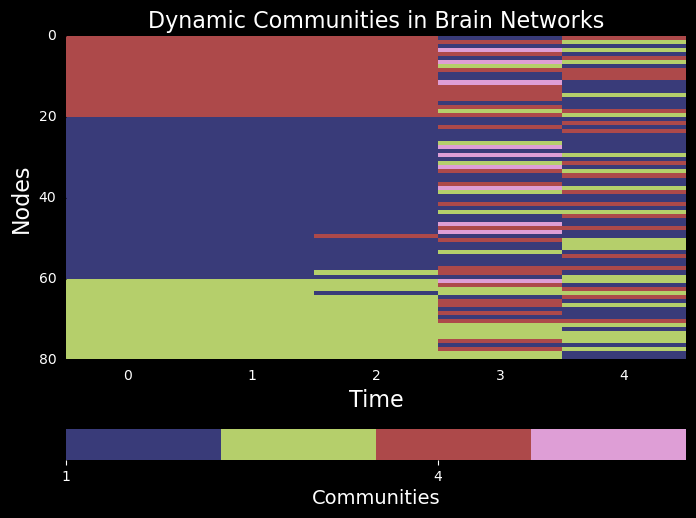

In [203]:
#After alignment

community_tracker(sbm_graphs,remapped_partition)

### Inferential methods of temporal community detection ###

As discussed in class 09, modularity maximization community detection techniques are flawed. See [this post](https://skewed.de/lab/posts/modularity-harmful/) by Tiago Peixoto for an overview on why modularity maximization is considered problematic.

[Graph-tool](https://graph-tool.skewed.de/) instead utilizes inferential methods of community detection. Namely, graph-tool uses a description length minimization technique to infer stochastic block model structure from networks.


**Try implementing the static community detection + community matching technique below using inferential community detection for the community detection portion.**

Again, we will use our multilayer sbm graph as our example.

In [178]:

import graph_tool.all as gt

#convert to graph-tool

gt_layers = []
for G in sbm_graphs:
    gt_G = gt.Graph(directed=False)
    
    #add vertices
    gt_G.add_vertex(G.number_of_nodes())

    #add nodes
    for u, v in G.edges():
        gt_G.add_edge(u,v)
    gt_layers.append(gt_G)


#Run minimize description length

layer_partitions = []
for layer in gt_layers:
    state = gt.minimize_blockmodel_dl(layer)
    blocks = state.get_blocks()
    communities = {node:blocks[node] for node in layer.vertices()}
    layer_partitions.append(communities)



######


In [ ]:
#Your Turn: Run the community alignment procedure from above
#Note the formatting of layer_partitions.


_____
# Characterizing Temporal Community Structure #




## Diagnostics/Metrics ##

Now that we have our multilayer community structure, we can calculate diagnostic measures. These will allow us to compare our graphs to other multilayer graphs, which may be necessary for analysis.

### Mean Module Size ###

The first metric, which we will calculate for each module, is **mean module size** (*s*). This is the mean number of nodes in a given community across all time windows in which that community exists.


In [1219]:
#code for calculating mean community size

def mean_s(module, multilayer_partition):
    """
    Calculates mean module size (number of nodes per community) for a given module across all time windows
    in which it exists.

    Parameters
    ------------
    module: integer, string
    Name of the module for which we are calculating s.
    
    multilayer_partition: list of lists
    List with a list for each layer of the multilayer graph.
    Each layer contains, in order, the modular affiliations for each node of the graph.

    Outputs
    -----------
    mean_size: float
    Mean community size
    """

    node_counts = []

    for layer_partition in multilayer_partition:
        node_count = 0
        for aff in layer_partition:
            if aff == module:
                node_count += 1
        node_counts.append(node_count)

    #removing timepoints in which community does not exist
    node_counts = [item for item in node_counts if item != 0] 
    mean_size = np.mean(node_counts)

    return mean_size
        


In [1220]:
multilayer_graph_name = "sbm multilayer"
module = 2
s = mean_s(module,sbm_partitions_lists)

print(f"The mean module size for module {module} in {multilayer_graph_name} is {s}")

The mean module size for module 2 in sbm multilayer is 21.4


### Stationarity ###

The next metric we will calculate is **stationarity** ($\zeta$). This is defined as the mean similarity in nodal composition of modules over consecutive time steps (Bassett et al., 2011). Greater stationarity would indicate a more smooth or stable modular configuration evolution.

First, we start by calculating the autocorrelation function $U(t,t+m)$ of two states of the same community $G(t)$ at *m* time steps apart with this formula:

  $$
  \huge{U(t, t+m) = \frac{|G(t) \cap G(t+m)|}{|G(t) \cup G(t+m)|}}
  $$

  $|G(t) \cap G(t+m)|$ is the number of nodes that are in both $G(t)$ and $G(t+m)$.
  
  $|G(t) \cup G(t+m)|$ is the total number of nodes in $G(t) \cup G(t+m)$

The stationarity of a community is:


$$
\huge{\zeta = \frac{\sum_{t=t_0}^{t^'-1} U(t,t+1)}{t^' - t_0 -1}}
$$

  
  

**Can you write a function to calculate stationarity for a given module, and mean stationarity across all the modules in a graph?**

In [1222]:
# Your Turn



def stationarity(module, multilayer_partition):
    """
    Provide description here

    Parameters
    ------------
    module: integer, string
    Name of the module for which we are calculating s.
    
    multilayer_partition: list of lists
    List with a list for each layer of the multilayer graph.
    Each layer contains, in order, the modular affiliations for each node of the graph.

    Outputs
    -----------
    stationarity: float
    
    """


    pass

def mean_stationarity(module, multilayer_partition):
    """
    Provide description here

    Parameters
    ------------
    multilayer_partition: list of lists
    List with a list for each layer of the multilayer graph.
    Each layer contains, in order, the modular affiliations for each node of the graph.

    Outputs
    -----------
    mean_stationarity: float
    
    """


    pass


### Flexibility ($f_i$) ###

  Flexibility is another metric from Bassett et al., 2011. The flexibility of a node is the number of times that it changes modular assignment over all timepoints in a multilayer graph, normalized by the total number of possible changes.

  The flexibility of an entire network is the mean flexibility over all nodes.
      $$
        \huge{F = \frac{1}{N}\sum_{i=1}^{N}f_i}
      $$
    
  

In [1224]:
#code for calculating network flexibility

def flexibility(multilayer_G, multilayer_partitions):
    """

    Calculates average flexibility across a multilayer network given 
    network partitions for each layer.

    Parameters
    --------------
    multilayer_G: list 
    List of networkx graphs that constitute your temporal network.

    multilayer_partitions: list of lists
    List with a list for each layer of the multilayer graph.
    Each layer contains, in order, the modular affiliations for each node of the graph.

    Outputs
    ------------
    avg_flexibility: float
    Average flexibility across the multilayer network.


    """

    nodes = list(multilayer_G[0].nodes())

    flexibilities = []
    
    for node in nodes:
        state_0 = multilayer_partitions[0][node]
        states =[state_0]
        changes = 0
        for i in range(1,len(multilayer_G)):
            partition = multilayer_partitions[i]
            affiliation = partition[node]
            
            if affiliation != states[-1]:
                changes +=1
            states.append(affiliation)
        possible_changes = len(states) - 1
        flexibility = changes/possible_changes
        flexibilities.append(flexibility)

    avg_flexibility = np.mean(flexibilities)
    
        
        

    return avg_flexibility




In [1225]:
f = flexibility(multilayer_G, membership)
multilayer_graph_name = "sbm multilayer"

print(f"The flexibility of {multilayer_graph_name} is {f}")



The flexibility of sbm multilayer is 0.740625


### Multilayer Generalization of Q ###

In class 08, we learned that modularity, $Q$, is a metric for assessing the extent to which nodes are organized into communities. Q measures the difference between the actual number of intra-community edges compared to the expected number. It is calculated as follows:


> The modularity, $Q$, of a given partition $C$ of our adjacency matrix $A$ is:
> $$Q (A,C) = \frac{1}{2M} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2M} \right) \delta (C_i,C_j) $$
> Where:
> - $ A_{ij} $ is the element of the adjacency matrix (1 if there is an edge between nodes $i$ and $j$, 0 otherwise).
> - $ k_i $ and $ k_j $ are the degrees of nodes $i$ and $j$, respectively.
> - $ M $ is the total number of edges in the network.
> - $ \delta(C_i, C_j) $ is a Kronecker delta, equal to 1 if nodes $i$ and $j$ are in the same community, and 0 otherwise.


Using the notation from Mucha et al., 2010, this is re-written as: $Q = \frac{1}{2\mu} \sum_{ij} ( A_{ij} - P_{ij})\delta(g_{i}, g_{j})$.

In Mucha et al., 2010, the authors build upon this formula, introducing a generalization for multilayer networks:

$Q = \frac{1}{2\mu} \sum_{ijsr} \Big[ \big( A_{ijs} - \gamma_s \frac{k_{is} k_{js}}{2 m_s} \big) \delta_{sr} + \delta_{ij} C_{jsr} \Big] \delta(g_{is}, g_{jr})$

Where:
- $ A_{ij} $ is the element of the adjacency matrix between nodes $i$ and $j$ in layer $s$.
- $ k_{is} $ and $ k_{js} $ are the degrees of nodes $i$ and $j$ in layer $s$.
- $ m_s $ is the total number/weight of edges in layer $s$.
- $\gamma_s$ is the resolution parameter for layer $s$.
- $C_{jsr}$ is the interslice coupling between node $j$ in slice $s$ to node $j$ in slice $r$
- $g_{is}$ is the community assignment of node $i$ in layer $s$
- $ \delta(C_i, C_j) $ is a Kronecker delta, equal to 1 if nodes $i$ and $j$ are in the same community, and 0 otherwise.
- $\mu$ is a normalization factor

**Let's write a function to calculate multilayer Q.**

In [232]:


def multilayer_Q(multilayer_G,multilayer_partitions,C):
    """

    Calculates multilayer Q.

    Parameters
    --------------
    multilayer_G: list 
    List of networkx graphs that constitute your temporal network.

    multilayer_partitions: list of lists
    List with a list for each layer of the multilayer graph.
    Each layer contains, in order, the modular affiliations for each node of the graph.

    C: float
    Interslice coupling parameter


    Outputs
    ------------
    Q: float
    multilayer Q

    """
    def remap_partition(partition):
        """
        Converts and remaps a partition to a list-of-lists structure suitable for modularity calculations.

        This function remaps the input partition (whether it's in dictionary form or a flat list of community labels) 
        to a list-of-lists format, where each list represents a community and contains the nodes in that community. 
        The function also ensures that community labels are contiguous integers starting from 0, which is typically 
        required for modularity-based algorithms.
        """

        # if partition is a dictionary where the keys are nodes and values communities
        if type(partition)==dict:
            unique_comms = np.unique(list(partition.values()))
            comm_mapping = {i:ix for ix,i in enumerate(unique_comms)}
            for i,j in partition.items():
                partition[i] = comm_mapping[j]

            unique_comms = np.unique(list(partition.values()))
            communities = [[] for i in unique_comms]
            for i,j in partition.items():
                communities[j].append(i)
                
            return communities

        # if partition is a list of community assignments
        elif type(partition)==list and\
                not any(isinstance(el, list) for el in partition):
            unique_comms = np.unique(partition)
            comm_mapping = {i:ix for ix,i in enumerate(unique_comms)}
            for i,j in enumerate(partition):
                partition[i] = comm_mapping[j]

            unique_comms = np.unique(partition)
            communities = [[] for i in np.unique(partition)]
            for i,j in enumerate(partition):
                communities[j].append(i)

            return communities

        # otherwise assume input is a properly-formatted list of lists
        else:
            communities = partition.copy()
            return communities

    
    num_layers = len(multilayer_G)
    num_nodes = len(multilayer_G[0].nodes())
    remapped = [remap_partition(p) for p in multilayer_partitions]
    


    #we should now have a list-of-lists for each layer/timepoint
    multilayer_Q = 0
    sum_m = 0
    sum_C = C*num_layers
    
    for s in range(num_layers):
        G = multilayer_G[s]
        communities = remapped[s]
        
        # Total weight of edges in the layer (or number of edges if unweighted)
        if nx.is_weighted(G):
            m = G.size(weight='weight')
            degree = dict(G.degree(weight='weight'))  # Weighted degree for each node
        else:
            m = G.number_of_edges()  # Number of edges in the graph
            degree = dict(G.degree())  # Degree for each node (unweighted)
    
        # Modularity score
        modularity_score = 0.0
        
        # Loop over all pairs of nodes i, j within the same layer
        for community in communities:
            for i in community:
                for j in community:
                    # Get the weight of the edge between i and j, or assume weight 1 if unweighted
                    if G.has_edge(i, j):
                        A_ij = G[i][j].get('weight', 1)  # Use weight if available, otherwise assume 1
                    else:
                        A_ij = 0  # No edge between i and j
    
                    # Expected number of edges (or weighted edges) between i and j in a random graph
                    expected_edges = (degree[i] * degree[j]) / (2 * m)
    
                    # Contribution to modularity
                    modularity_score += (A_ij - expected_edges)
    
        # Normalize by the total number of edges (or total edge weight) 2m
        
        multilayer_Q += modularity_score
        sum_m += m

    Q_inter = 0
    for s in range(num_layers-1):
        for i in range(num_nodes):
            same = int(multilayer_partitions[s][i] == multilayer_partitions[s+1][i])
            Q_inter += C * same

    multilayer_Q = multilayer_Q + Q_inter
    mu = sum_m + sum_C*(num_layers-1)
    multilayer_Q = multilayer_Q / (2*mu)
    return multilayer_Q
        



In [1228]:
multilayer_Q(multilayer_G_sbm,membership_sbm,C=0.1)

0.17013152312065083

Now, we can compare these diagnostics across networks.

Your turn: Write a function to output a diagnostic report for a given graph. Then use that function to generate reports for two different multilayer graphs. Compare.

In [1230]:
def temporal_diagnostics(multilayer_G, multilayer_partitions):
    """
    Generates report with diagnostic measures for given network
    """
    pass

In [1231]:
# #Compare across networks

# temporal_diagnostics(G1, partition1)
# temporal_diagnostics(G2, partition2)

----------------
# Null model comparison  #

In order to assess our multilayer networks, we can compare the diagnostic measures calculated above to those derived from **null models**. Null models are randomized networks that preserve certain characteristics of a given network of interest while randomizing others. They allow us to assess whether characteristics of our graph are due to chance, or due to unique topological features not found in randomized versions of our graph. See again Bassett et al., 2011, for an example in which null models are compared to human brain connectivity-derived networks. 

There are various features of a graph of interest that can be randomly shuffled to generate null models. In Bassett et al., 2011, null models are generated in three different ways. Below, we will generate these three different types of null models.

## 1. Connectional null models ##

   Here, edges within each layer of a multilayer graph are randomized.

![Bassett et al., 2011. Figure 3c](connectional.png)




First, we'll need this:

In [1235]:
def degree_preserving_randomization(G, n_iter=1000):
    """
    Perform degree-preserving randomization on a graph.

    Degree-preserving randomization, also known as edge swapping or rewiring, 
    is a method for creating randomized versions of a graph while preserving 
    the degree distribution of each node. This is achieved by repeatedly 
    swapping pairs of edges in the graph, ensuring that the degree (number of 
    edges connected) of each node remains unchanged. The result is a graph 
    with the same degree distribution but a randomized edge structure, which 
    can be used as a null model to compare with the original network.

    Parameters
    ----------
    G : networkx.Graph
        The input graph to be randomized. The graph can be directed or 
        undirected, but it must be simple (i.e., no self-loops or parallel edges).

    n_iter : int, optional (default=1000)
        The number of edge swap iterations to perform. A higher number of 
        iterations leads to more randomization, but the degree distribution 
        remains preserved. Typically, the number of iterations should be 
        proportional to the number of edges in the graph for sufficient 
        randomization.

    Returns
    -------
    G_random : networkx.Graph
        A randomized graph with the same degree distribution as the original 
        graph `G`, but with a shuffled edge structure.

    Notes
    -----
    - This method works by selecting two edges at random, say (u, v) and (x, y), 
      and attempting to swap them to (u, y) and (x, v) (or (u, x) and (v, y)), 
      ensuring that no self-loops or parallel edges are created in the process.
    - Degree-preserving randomization is particularly useful for creating null 
      models in network analysis, as it allows for the investigation of whether 
      specific network properties (e.g., clustering, path lengths) are a result 
      of the network's structure or just its degree distribution.
    - The effectiveness of randomization depends on the number of iterations 
      (`n_iter`). As a rule of thumb, using about 10 times the number of edges 
      in the graph for `n_iter` often provides sufficient randomization.
    
    Example
    -------
    >>> import networkx as nx
    >>> G = nx.erdos_renyi_graph(10, 0.5)
    >>> G_random = degree_preserving_randomization(G, n_iter=100)
    
    Citations
    ---------
    Milo, R., Shen-Orr, S., Itzkovitz, S., Kashtan, N., Chklovskii, D., & Alon, U. (2002). 
    Network motifs: simple building blocks of complex networks. *Science*, 298(5594), 824-827.
    
    Maslov, S., & Sneppen, K. (2002). Specificity and stability in topology of protein networks. 
    *Science*, 296(5569), 910-913.
    """

    G_random = G.copy()
    edges = list(G_random.edges())
    num_edges = len(edges)

    for _ in range(n_iter):
        # Select two random edges (u, v) and (x, y)
        edge1_id = np.random.choice(list(range(len(edges))))
        u, v = edges[edge1_id]
        edge2_id = np.random.choice(list(range(len(edges))))
        x, y = edges[edge2_id]

        # Avoid selecting the same edge pair or creating self-loops
        if len({u, v, x, y}) == 4:
            # Swap the edges with some probability
            if np.random.rand() > 0.5:
                # Swap (u, v) with (u, y) and (x, v)
                if not (G_random.has_edge(u, y) or G_random.has_edge(x, v)):
                    G_random.remove_edge(u, v)
                    G_random.remove_edge(x, y)
                    G_random.add_edge(u, y)
                    G_random.add_edge(x, v)
            else:
                # Swap (u, v) with (u, x) and (v, y)
                if not (G_random.has_edge(u, x) or G_random.has_edge(v, y)):
                    G_random.remove_edge(u, v)
                    G_random.remove_edge(x, y)
                    G_random.add_edge(u, x)
                    G_random.add_edge(v, y)

        # Update edge list after changes
        edges = list(G_random.edges())


    return G_random

In [1236]:
#First, try it yourself

def connectional_null(multilayer_G,n_models=100,degree_preserved=False):
    """

    Generates n connectional null models.

    Outputs list of graphs.

    Parameters
    -------------
    multilayer_G: list 
    List of networkx graphs that constitute your temporal network.

    n_models: integer (optional)
    Number of null models to generate.

    degree_preserved: boolean
    Whether or not degree distribution should be preserved in null models.

    Outputs
    ------------
    G_randoms: list
    List of null models (networkx graphs)


    
    """
    G_working = G.copy()

    


        
    pass

In [1237]:
#Solution
def connectional_null(multilayer_G,n_models=100,degree_preserved=False):
    """

    Generates n connectional null models.

    Outputs list of graphs.

    Parameters
    -------------
    multilayer_G: list 
    List of networkx graphs that constitute your temporal network.

    n_models: integer (optional)
    Number of null models to generate.

    degree_preserved: boolean
    Whether or not degree distribution should be preserved in null models.

    Outputs
    ------------
    G_randoms: list of lists
    A list of null models (networkx graphs) for each layer of input graph


    
    """
    G_randoms = []
    
    for layer in multilayer_G:
        G_working = layer.copy()
    
        N = G_working.number_of_nodes()
        M = G_working.number_of_edges()
    
        layer_randoms = []
    
        
        if degree_preserved==False:
            for i in range(n_models):
                G_random = nx.gnm_random_graph(N,M)
                layer_randoms.append(G_random)
            
        else:
            for i in range(n_models):
                G_random = degree_preserving_randomization(G_working)
                layer_randoms.append(G_random)
            
        G_randoms.append(layer_randoms)
        
    return G_randoms

## 2. Nodal null models ##

Here, the connections between nodes across layers are shuffled. For example, instead of edge1---edge1---edge1, you might see edge1---edge4---edge23.


![Bassett et al., 2011. Figure 3c](nodal.png)


In [1240]:
#First, try it yourself

def nodal_null(multilayer_G,n_models=100):
    """

    Generates n connectional null models.

    Outputs a list of multilayer graphs.

    Parameters
    -------------
    multilayer_G: list 
    List of networkx graphs that constitute your temporal network.

    n_models: integer (optional)
    Number of null models to generate.

    degree_preserved: boolean
    Whether or not degree distribution should be preserved in null models.

    Outputs
    ------------
    G_randoms: list of lists
    A list of null models (networkx graphs) for each layer of input graph
    
    """

    pass
    

In [227]:
#Solution
def nodal_null(multilayer_G,n_models=100):
    """

    Generates n connectional null models.

    Outputs a list of multilayer graphs.

    Parameters
    -------------
    multilayer_G: list 
    List of networkx graphs that constitute your temporal network.

    n_models: integer (optional)
    Number of null models to generate.

    degree_preserved: boolean
    Whether or not degree distribution should be preserved in null models.

    Outputs
    ------------
    G_randoms: list of lists
    A list of null models (networkx graphs) for each layer of input graph
    
    """
    num_layers = len(multilayer_G)

    #Get list of nodes in first layer
    G_t1 = multilayer_G[0]
    t1_nodes = list(G_t1.nodes())

    G_randoms = []

    for i in range(n_models):

        shuffled_Gs = [G_t1.copy()]
    
    
        #scramble for each subsequent layer
        for layer in range(num_layers-1):
            shuffled_nodes = t1_nodes.copy()
            np.random.shuffle(shuffled_nodes)
            node_mapping = dict(zip(t1_nodes,shuffled_nodes))
    
            G_t = multilayer_G[layer]
            G_copy = G_t.copy()
            G_shuffled = nx.relabel_nodes(G_copy,node_mapping)
            shuffled_Gs.append(G_shuffled)
            
        G_randoms.append(shuffled_Gs)

    return G_randoms
    

## 3. Temporal null models ##

Here, the ordering of the layers of a multilayer graph is shuffled.

![Bassett et al., 2011. Figure 3c](temporal.png)


In [1244]:
#First, try it yourself

def temporal_null(multilayer_G,n_models=100):
    
    """
    Generates n connectional null models.

    Outputs a list of multilayer graphs.

    Parameters
    -------------
    multilayer_G: list 
    List of networkx graphs that constitute your temporal network.

    n_models: integer (optional)
    Number of null models to generate.

    degree_preserved: boolean
    Whether or not degree distribution should be preserved in null models.

    Outputs
    ------------
    G_randoms: list of lists
    A list of null models (networkx graphs) for each layer of input graph
    
    """
    pass
        

    

In [1245]:
#Solution

def temporal_null(multilayer_G,n_models=100):
    
    """
    Generates n temporal null models.

    Outputs a list of multilayer graphs.

    Parameters
    -------------
    multilayer_G: list 
    List of networkx graphs that constitute your temporal network.

    n_models: integer (optional)
    Number of null models to generate.

    degree_preserved: boolean
    Whether or not degree distribution should be preserved in null models.

    Outputs
    ------------
    G_randoms: list of lists
    A list of null models (networkx graphs) for each layer of input graph
    
    """
    shuffled_Gs = []
    for i in range(n_models):

        multilayer_copy = [G.copy() for G in multilayer_G]

        np.random.shuffle(multilayer_copy)

        shuffled_Gs.append(multilayer_copy)

    return shuffled_Gs
        

    

Now, we can calculate multilayer graph diagnostics/metrics from these null models and plot the distributions. We will check if our graph of interest's flexibility is similar to that seen in random graphs.



In [234]:
#First, generate 1000 nodal null graphs

null_models = nodal_null(multilayer_G_sbm,n_models=1000)

null_metrics=[]
for multilayer_G in null_models:
    #perform community detection
    membership = leiden_cd(multilayer_G,0.001)


    #calculate metric of choice
    m = multilayer_Q(multilayer_G,membership,C=0.01)
    null_metrics.append(m)


    

Your graph's value for Multilayer Q is in the 100.000000th percentile


Text(0.168136073232921, 250, 'Your Value')

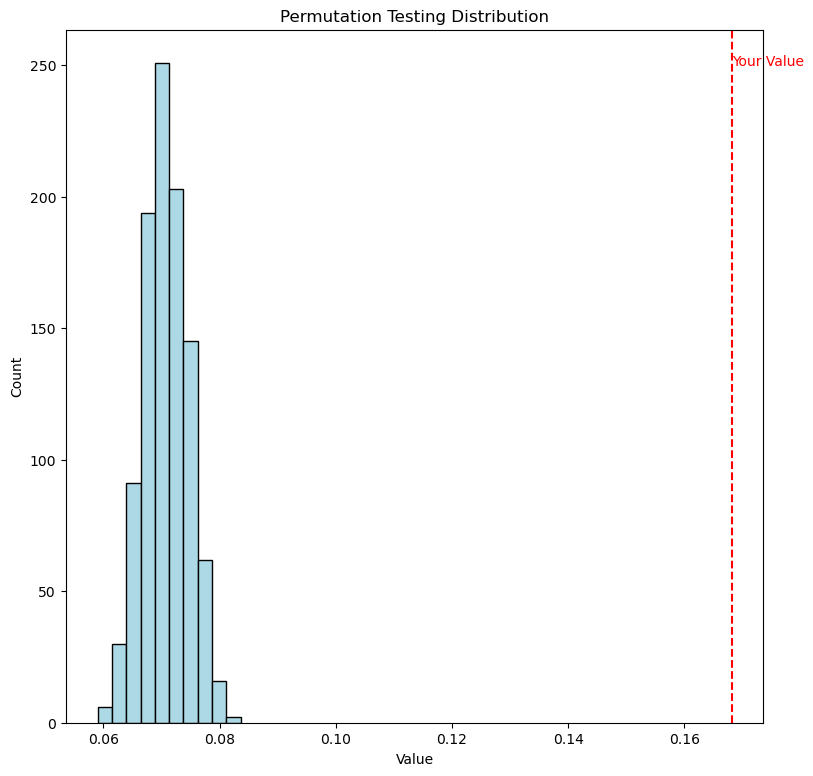

In [243]:
from scipy import stats

fig,ax=plt.subplots(1,1,figsize=(9,9))

plt.hist(null_metrics,edgecolor="black",color='lightblue')

your_g_metric = multilayer_Q(multilayer_G_sbm,partitions,C=0.001)

plt.axvline(x=your_g_metric, color='r', linestyle='--', label='Your Value')
percentile = stats.percentileofscore(null_metrics, your_g_metric, kind='mean')
metric_name = "Multilayer Q"
print(f"Your graph's value for {metric_name} is in the {percentile:2f}th percentile")

ax.set_title("Permutation Testing Distribution")
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax.text(your_g_metric,250,'Your Value',color='red')

____

## Advanced Topics ##

1. **Other Relevant Python Packages: cdlib, networkx-temporal, pymnet**
   
   These python packages are also relevant for multilayer network analysis.
   
2. **Temporal Trade Off Community Detection (TToCD)**

   
   This is another approach to multilayer community detection in which the previous timepoint's network is taken into account when
   partitioning a given window. See Hamed, et al., 2024 for more information, and see Cdlib for implementation.
   

____
## References ##
1. Bassett, D. S., Porter, M. A., Wymbs, N. F., Grafton, S. T., Carlson, J. M., & Mucha, P. J. (2013). Robust detection of dynamic community structure in networks. *Chaos: An Interdisciplinary Journal of Nonlinear Science*, 23(1), 013142. https://doi.org/10.1063/1.4790830
2. Bassett, D. S., Wymbs, N. F., Porter, M. A., Mucha, P. J., Carlson, J. M., & Grafton, S. T. (2011). Dynamic reconfiguration of human brain networks during learning. *Proceedings of the National Academy of Sciences*, 108(18), 7641–7646. https://doi.org/10.1073/pnas.1018985108
3. Bazzi, M., Porter, M. A., Williams, S., McDonald, M., Fenn, D. J., & Howison, S. D. (2016). Community Detection in Temporal Multilayer Networks, with an Application to Correlation Networks. Multiscale Modeling & Simulation, 14(1), 1–41. https://doi.org/10.1137/15M1009615
4. Ghawi, R., & Pfeffer, J. (2022). A community matching based approach to measuring layer similarity in multilayer networks. Social Networks, 68, 1–14. https://doi.org/10.1016/j.socnet.2021.04.004
5. Hamed, I., Rebhi, W. & Saoud, N.B.B. A comprehensive view of community detection approaches in multilayer social networks. Soc. Netw. Anal. Min. 14, 103 (2024). https://doi.org/10.1007/s13278-024-01266-1
6. Lancichinetti, A., Fortunato, S., & Radicchi, F. (2008). Benchmark graphs for testing community detection algorithms. Physical Review E, 78(4), 046110. https://doi.org/10.1103/PhysRevE.78.046110
7.  Mucha, P. J., Richardson, T., Macon, K., Porter, M. A., & Onnela, J.-P. (2010). Community Structure in Time-Dependent, Multiscale, and Multiplex Networks. *Science*, 328(5980), 876–878. https://doi.org/10.1126/science.1184819
8. Peixoto, T. P., & Rosvall, M. (2017). Modelling sequences and temporal networks with dynamic community structures. *Nature Communications*, 8(1), 582. https://doi.org/10.1038/s41467-017-00148-9
9. Passos, N. A. R. A., Carlini, E., & Trani, S. (2025). NetworkX-Temporal: Building, manipulating, and analyzing dynamic graph structures. *SoftwareX*, 31, 102277. https://doi.org/10.1016/j.softx.2025.102277
10. Rossetti, G., Milli, L., & Cazabet, R. (2019). CDLIB: A python library to extract, compare and evaluate communities from complex networks. Applied Network Science, 4(1), 52. https://doi.org/10.1007/s41109-019-0165-9
11. Traag, V. A., Waltman, L., & Van Eck, N. J. (2019). From Louvain to Leiden: Guaranteeing well-connected communities. Scientific Reports, 9(1), 5233. https://doi.org/10.1038/s41598-019-41695-z





